In [ ]:
import math
import random
import numpy as np
import pandas as pd

# Get rid of the NumPy SciPy warning.
import warnings
warnings.filterwarnings('ignore')

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

from xgboost import XGBClassifier
from xgboost import XGBRegressor

# Utility functions from Mutual Information Tutorial
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

# Utility functions from Principal Component Analysis Tutorial
def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings

def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

# Metadata for plots.
feature_meta = {
    'fixed acidity': {
        'label': 'Fixed Acidity (g/L)',
        'corr_order': 7
    },
    'volatile acidity': {
        'label': 'Volatile Acidity (g/L)',
        'corr_order': 2
    },
    'citric acid': {
        'label': 'Citric Acid (g/L)',
        'corr_order': 4
    },
    'residual sugar': {
        'label': 'Residual Sugar (g/L)',
        'corr_order': 11
    },
    'chlorides': {
        'label': 'Chlorides (g/L)',
        'corr_order': 8
    },
    'free sulfur dioxide': {
        'label': 'Free Sulfur Dioxide (mg/L)',
        'corr_order': 10
    },
    'total sulfur dioxide': {
        'label': 'Total Sulfur Dioxide (mg/L)',
        'corr_order': 5
    },
    'density': {
        'label': 'Density (g/mL)',
        'corr_order': 6
    },
    'pH': {
        'label': 'pH',
        'corr_order': 9
    },
    'sulphates': {
        'label': 'Sulphates (g/L)',
        'corr_order': 3
    },
    'alcohol': {
        'label': '% Alcohol by Volume',
        'corr_order': 1
    },
    'quality': {
        'label': 'Quality'
    },
}

# Plot histograms.
def plot_histograms(X, y):
    fig, sub_axes = plt.subplots(6,2,figsize=(10,24))
    for i,col in enumerate(X.columns):
        axes = sns.histplot(data=X, x=col, bins=30, ax=sub_axes[i//2,i%2])
        txt = axes.set(xlabel=feature_meta[col]['label'])
    axes = sns.histplot(x=y, bins=30, ax=sub_axes[5,1])
    txt = axes.set(xlabel='Quality')
    fig.tight_layout()

# Plot feature triplets.
def plot_feature(train_X, feature, train_y, ylim):
    ylabel = feature_meta[feature]['label']
    fig, sub_axes = plt.subplots(1,3,figsize=(10,4))
    axes = sns.boxplot(data=train_X, x=train_y, y=feature, ax=sub_axes[0])
    txt = axes.set(xlabel='Quality', ylabel=ylabel)
    axes = sns.scatterplot(data=train_X, x=train_y, y=feature,
                           color='#bbb', edgecolor='black', ax=sub_axes[1])
    txt = axes.set(xlabel='Quality', ylabel=ylabel)
    axes = sns.kdeplot(data=train_X, y=feature, hue=train_y, fill=True,
                       palette='rocket', ax=sub_axes[2])
    txt = axes.set(xlabel='Kernel Density Estimate', ylabel=ylabel,
                   ylim=ylim)
    fig.tight_layout()

# Plot Premium/Non-Premium densities.
def plot_pnp_densities(X, y):
    fig, sub_axes = plt.subplots(6,2,figsize=(10,24))
    for i,col in enumerate(sorted(X.columns, key=lambda c: feature_meta[c]['corr_order'])):
        axes = sns.kdeplot(data=X, x=col, hue=y, fill=True,
                           ax=sub_axes[i//2,i%2])
        txt = axes.set(xlabel=feature_meta[col]['label'], ylabel='Kernel density estimate')
    fig.delaxes(sub_axes[5,1])
    fig.tight_layout()

def plot_scatters(X, y):
    fig, sub_axes = plt.subplots(2,2,figsize=(10,8))

    axes = sns.scatterplot(data=X, x='alcohol', y='volatile acidity',
                           hue=y, edgecolor='black', ax=sub_axes[0,0])
    txt = axes.set(title="Volatile Acidity vs. Alcohol",
                   xlabel=feature_meta['alcohol']['label'],
                   ylabel=feature_meta['volatile acidity']['label'])

    axes = sns.scatterplot(data=X, x='alcohol', y='sulphates',
                           hue=y, edgecolor='black', ax=sub_axes[0,1])
    txt = axes.set(title="Sulphates vs. Alcohol",
                   xlabel=feature_meta['alcohol']['label'],
                   ylabel=feature_meta['sulphates']['label'])

    axes = sns.scatterplot(data=X, x='volatile acidity', y='sulphates',
                           hue=y, edgecolor='black', ax=sub_axes[1,0])
    txt = axes.set(title="Sulphates vs. Volatile Acidity",
                   xlabel=feature_meta['volatile acidity']['label'],
                   ylabel=feature_meta['sulphates']['label'])

    fig.delaxes(sub_axes[1,1])
    fig.tight_layout()

def df_append(df, row):
    r = dict(row)
    index = r['index']
    del r['index']
    return pd.concat([df, pd.DataFrame(r, index=[index])])

def accuracy_by_threshold(model, tset_X, tset_y, vset_X, vset_y, drop_columns=[]):
    accuracies = []
    for i in range(len(tset_X)):
        accuracy = []
        linear = LinearRegression()
        t_X = tset_X[i].drop(drop_columns, axis=1)
        t_y = tset_y[i]
        v_X = vset_X[i].drop(drop_columns, axis=1)
        v_y = vset_y[i]
        model.fit(t_X, t_y)
        y_hat = model.predict(v_X)
        for j in range(0,1000):
            accuracy.append(np.mean((y_hat >= j/100) == (v_y >= 7)))
        accuracies.append(accuracy)

    mean_accuracy = []
    threshold = []
    for j in range(0,1000):
        sum = 0
        for i in range(5):
            sum += accuracies[i][j]
        mean_accuracy.append(sum/5)
        threshold.append(j/100)

    return (threshold, mean_accuracy)

def get_max_with_index(values):
    max_value = -math.inf
    max_i = -1
    for i,value in enumerate(values):
        if value > max_value:
            max_value = value
            max_i = i

    return (max_i, max_value)

def get_threshold_precision_recall(model, tset_X, tset_y, vset_X, vset_y,
                                   drop_columns=[], percent=0.03):
    thresholds = []
    y_hat = []
    for i in range(5):
        t_X = tset_X[i]
        t_X = t_X.drop(drop_columns, axis=1)
        t_y = tset_y[i]
        v_X = vset_X[i]
        v_X = v_X.drop(drop_columns, axis=1)
        v_y = vset_y[i]
        model.fit(t_X, t_y)
        y_hat.append(model.predict(v_X))
        y_h = y_hat[-1].copy()
        y_h.sort()
        y_h = np.flip(y_h)
        thresholds.append(y_h[round(percent*y_h.shape[0])-1])
    threshold = np.mean(thresholds)
    sd = np.std(thresholds)

    precisions = []
    recalls = []
    for i in range(5):
        precisions.append(np.mean(validation_set_y[i][y_hat[i] >= threshold] >= 7))
        recalls.append(np.mean(y_hat[i][validation_set_y[i] >= 7] >= threshold))

    return {
        'threshold_mean': np.mean(thresholds),
        'precision_mean': np.mean(precisions),
        'recall_mean': np.mean(recalls),
        'threshold_std': np.std(thresholds),
        'precision_std': np.std(precisions),
        'recall_std': np.std(recalls),
    }

def df_from_tpr(result):
    df = pd.DataFrame()
    df = df_append(df, {'index': 'Threshold', 'Mean': result['threshold_mean'],
                        'Standard Deviation': result['threshold_std']})
    df = df_append(df, {'index': 'Precision', 'Mean': result['precision_mean'],
                        'Standard Deviation': result['precision_std']})
    df = df_append(df, {'index': 'Recall', 'Mean': result['recall_mean'],
                        'Standard Deviation': result['recall_std']})
    return df

def get_classification_results(model, train_X, train_y, test_X, test_y):
    train_y_class = train_y >= 7
    model.fit(train_X, train_y_class)
    y_hat = model.predict(test_X)
    precision = np.sum(y_hat & (test_y >= 7))/np.sum(y_hat)
    results = pd.concat([test_X[y_hat == 1], test_y[y_hat == 1]], axis=1)
    return (precision, results)

def get_regression_results(model, train_X, train_y, test_X, test_y, threshold,
                           drop_columns=[]):
    t_X = train_X.drop(drop_columns, axis=1)
    t_y = train_y
    v_X = test_X.drop(drop_columns, axis=1)
    v_y = test_y
    model.fit(t_X, t_y)
    y_hat = model.predict(v_X)
    precision = np.sum((y_hat >= threshold) & (test_y >= 7))/np.sum(y_hat >= threshold)
    results = pd.concat([test_X[y_hat >= threshold], test_y[y_hat >= threshold]], axis=1)
    return (precision, results)

def plot_final_results(results):
    rows = (len(results) + 1)//2
    fig, sub_axes = plt.subplots(rows, 2, figsize=(10,rows*4))
    for i,k in enumerate(results.keys()):
        r = results[k]
        axes = sns.scatterplot(data=r, x='alcohol', y='volatile acidity',
                               hue=(r.quality >= 7), edgecolor='black',
                               ax=sub_axes[i//2,i%2])
        txt = axes.set(title=k, xlabel='% Alcohol by volume',
                       ylabel='Volatile acidity (g/L)', xlim=(8.1,15.2), ylim=(0.05,1.65))
    if (len(results)%2):
        fig.delaxes(sub_axes[rows - 1,len(results)%2])
    fig.tight_layout()

In [ ]:
!wget https://raw.githubusercontent.com/sarthak-tayal/CL-653/main/winequality-red.csv
dataset = pd.read_csv('/content/winequality-red.csv')

--2024-04-25 14:08:22--  https://raw.githubusercontent.com/sarthak-tayal/CL-653/main/winequality-red.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100951 (99K) [text/plain]
Saving to: ‘winequality-red.csv.1’

winequality-red.csv 100%[===================>]  98.58K  --.-KB/s    in 0.02s   

2024-04-25 14:08:22 (6.35 MB/s) - ‘winequality-red.csv.1’ saved [100951/100951]



In [ ]:
dataset.head()



,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [ ]:
dataset.shape

(1599, 12)

In [ ]:
df = dataset.describe().drop(['25%','50%','75%']).T
pd.concat([pd.DataFrame(dataset.isnull().sum(), columns=['isnull']), df], axis=1)

,isnull,count,mean,std,min,max
fixed acidity,0,1599.0,8.319637,1.741096,4.60000,15.90000
volatile acidity,0,1599.0,0.527821,0.179060,0.12000,1.58000
citric acid,0,1599.0,0.270976,0.194801,0.00000,1.00000
residual sugar,0,1599.0,2.538806,1.409928,0.90000,15.50000
chlorides,0,1599.0,0.087467,0.047065,0.01200,0.61100
free sulfur dioxide,0,1599.0,15.874922,10.460157,1.00000,72.00000
total sulfur dioxide,0,1599.0,46.467792,32.895324,6.00000,289.00000
density,0,1599.0,0.996747,0.001887,0.99007,1.00369
pH,0,1599.0,3.311113,0.154386,2.74000,4.01000
sulphates,0,1599.0,0.658149,0.169507,0.33000,2.00000


In [ ]:
dataset.drop_duplicates(inplace=True)


In [ ]:
# Separate factors and target.
X = dataset.drop('quality', axis=1)
y = dataset['quality']

# Split training and test sets.
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=1)
train_X.shape[0]

# Create a classification target for "premium" dataset (quality >= 7.)
train_y_class = train_y >= 7
train_y_class.name = 'Premium'
test_y_class = test_y >= 7
test_y_class.name = 'Premium'

# Split the training set into 5 folds to allow manual k-fold cross validation.
indexes = list(train_X.index)
random.seed(1)
random.shuffle(indexes)
train_set_X = []
train_set_y = []
validation_set_X = []
validation_set_y = []

k = 5
for i in range(k):
    start = round(i*train_X.shape[0]/k)
    end = round((i + 1)*train_X.shape[0]/k)
    train_set_X.append(train_X.drop(indexes[start:end]))
    train_set_y.append(train_y.drop(indexes[start:end]))
    validation_set_X.append(train_X.loc[indexes[start:end]])
    validation_set_y.append(train_y.loc[indexes[start:end]])

train_X_mu = train_X.mean()
train_X_std = train_X.std()
train_X_standard = (train_X - train_X_mu)/train_X_std

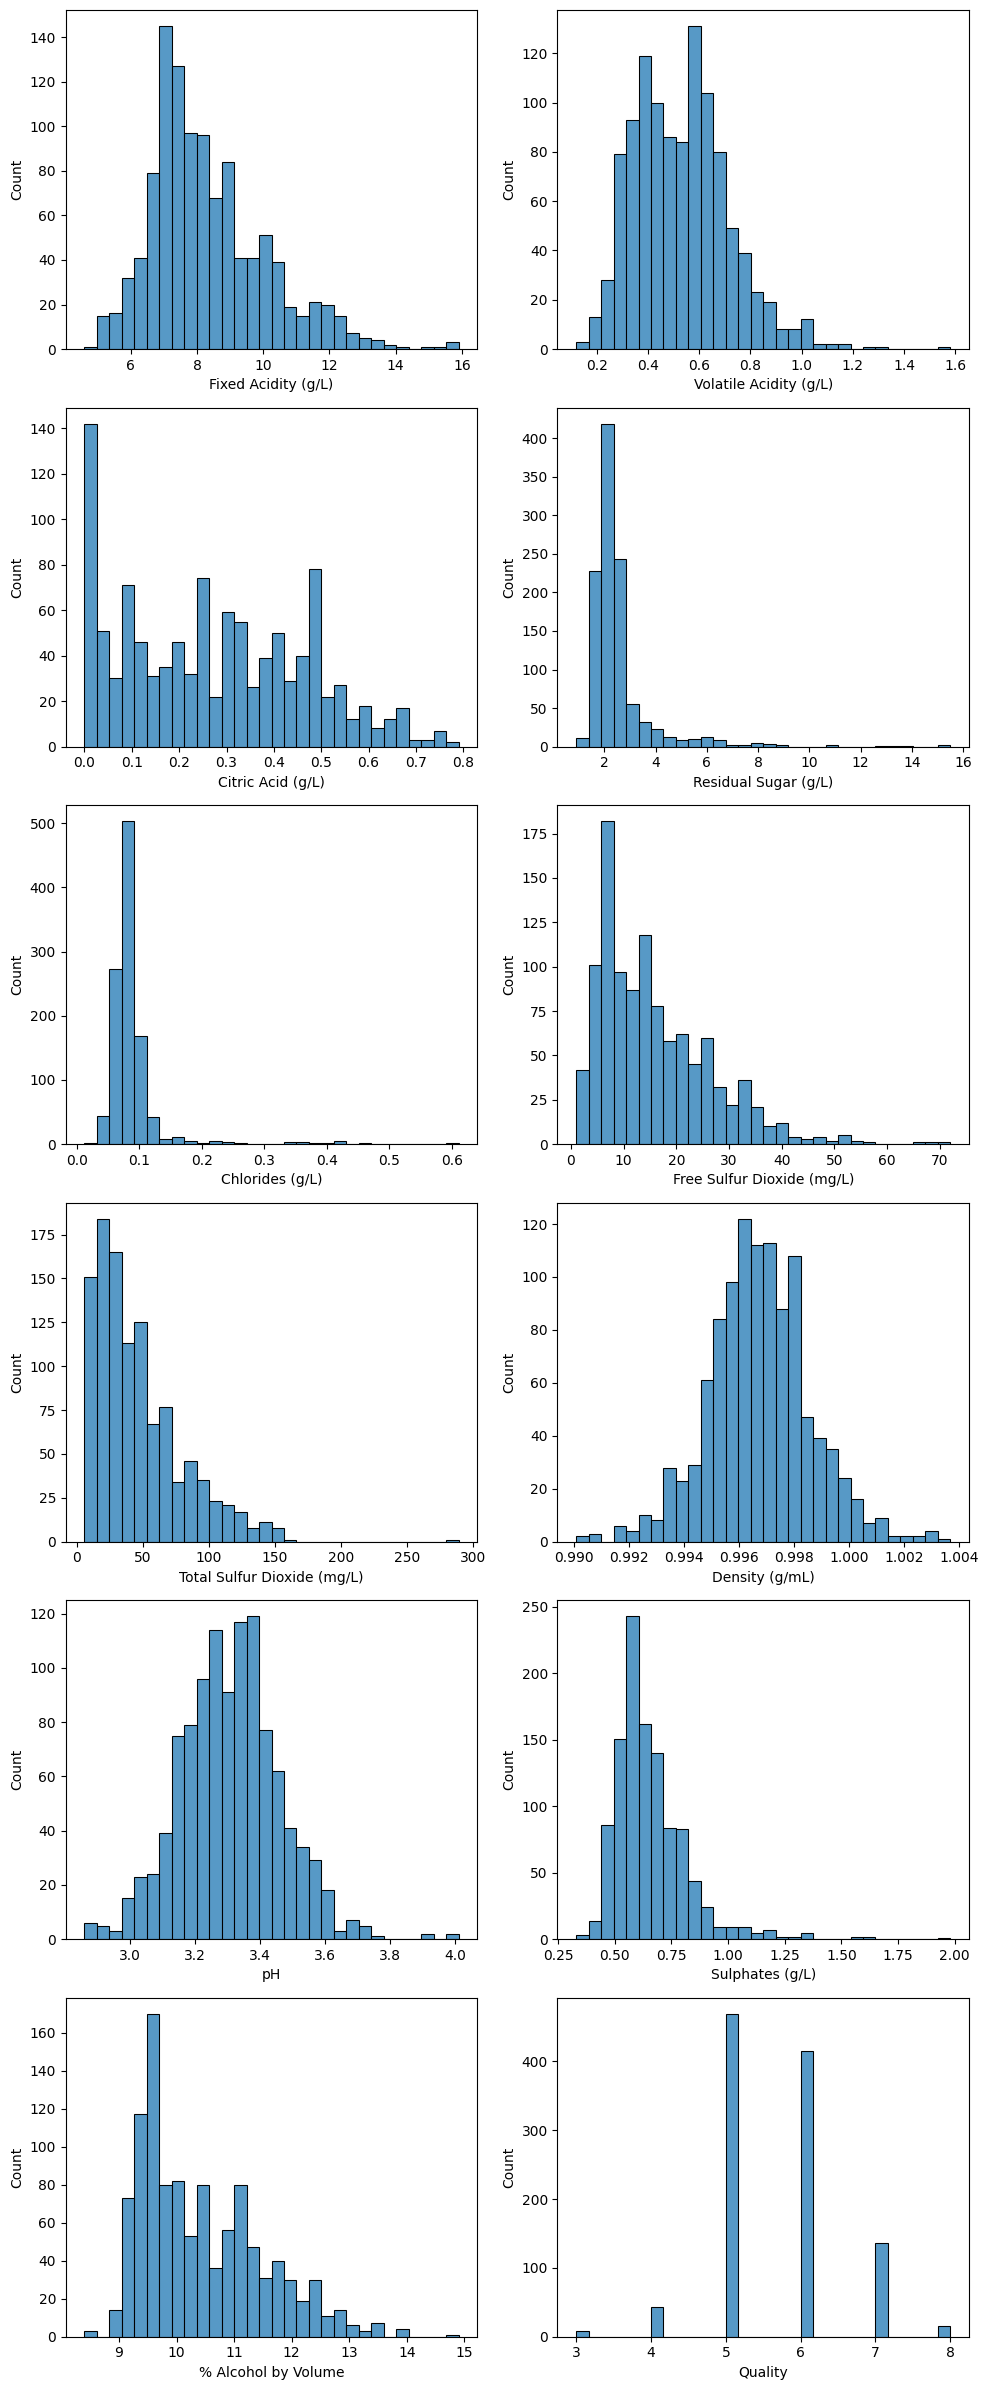

In [ ]:
plot_histograms(train_X, train_y)

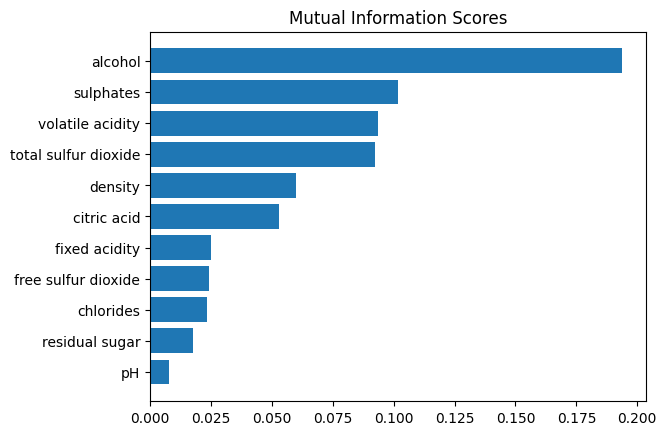

In [ ]:
mi_scores = make_mi_scores(train_X, train_y)
plot_mi_scores(mi_scores)

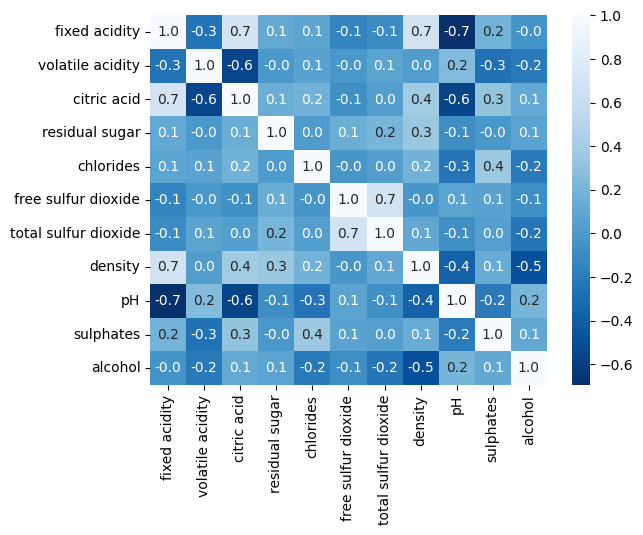

In [ ]:
txt = sns.heatmap(train_X.corr(), annot=True, fmt='.1f', cmap='Blues_r')

In [ ]:
corrs = [
    train_X['fixed acidity'].corr(train_y),
    train_X['volatile acidity'].corr(train_y),
    train_X['citric acid'].corr(train_y),
    train_X['residual sugar'].corr(train_y),
    train_X['chlorides'].corr(train_y),
    train_X['free sulfur dioxide'].corr(train_y),
    train_X['total sulfur dioxide'].corr(train_y),
    train_X['density'].corr(train_y),
    train_X['pH'].corr(train_y),
    train_X['sulphates'].corr(train_y),
    train_X['alcohol'].corr(train_y)
]
cols = train_X.columns
corrs_df = pd.DataFrame({'correlation': corrs, 'magnitude': np.abs(corrs)},
                  index=cols)
corrs_df.sort_values(by='magnitude', ascending=False, inplace=True)
corrs_df.drop('magnitude', axis=1, inplace=True)
corrs_df

,correlation
alcohol,0.481742
volatile acidity,-0.415462
sulphates,0.291671
citric acid,0.252418
total sulfur dioxide,-0.184950
density,-0.165334
fixed acidity,0.143761
chlorides,-0.103002
pH,-0.089427
free sulfur dioxide,-0.028626


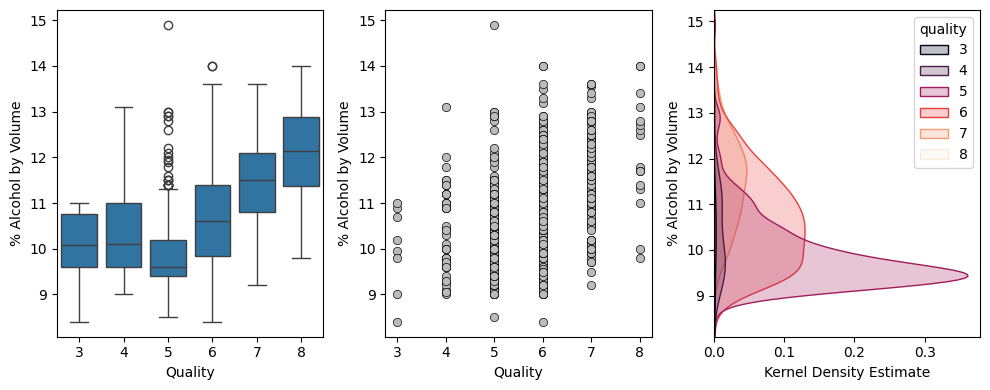

In [ ]:
plot_feature(train_X, 'alcohol', train_y, [8.1,15.25])


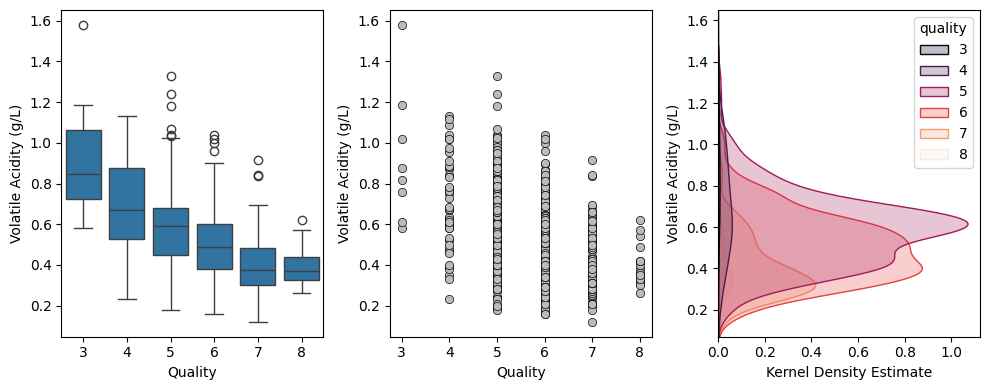

In [ ]:
plot_feature(train_X, 'volatile acidity', train_y, [0.07,1.65])


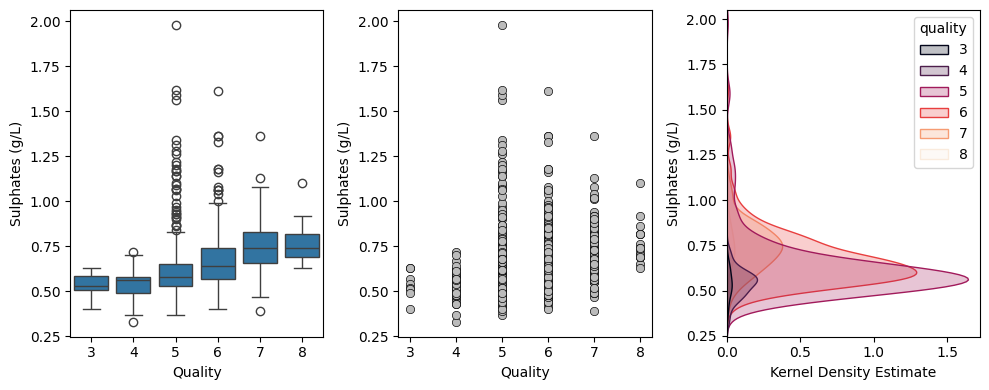

In [ ]:
plot_feature(train_X, 'sulphates', train_y, [0.245,2.05])

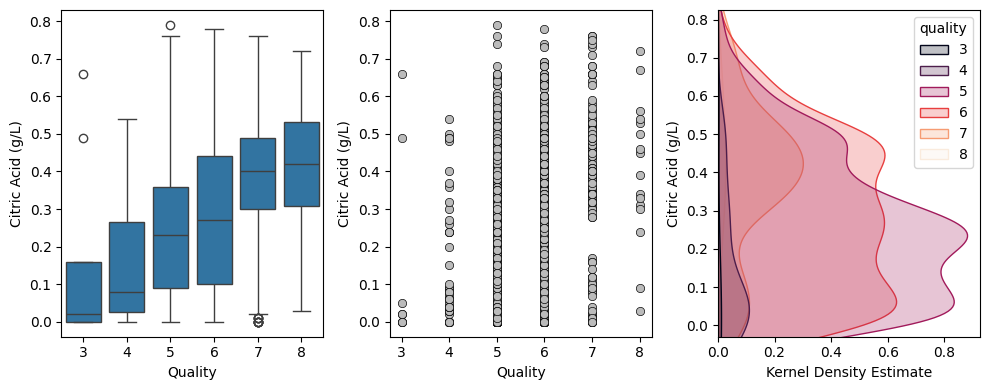

In [ ]:
plot_feature(train_X, 'citric acid', train_y, [-0.03,0.825])

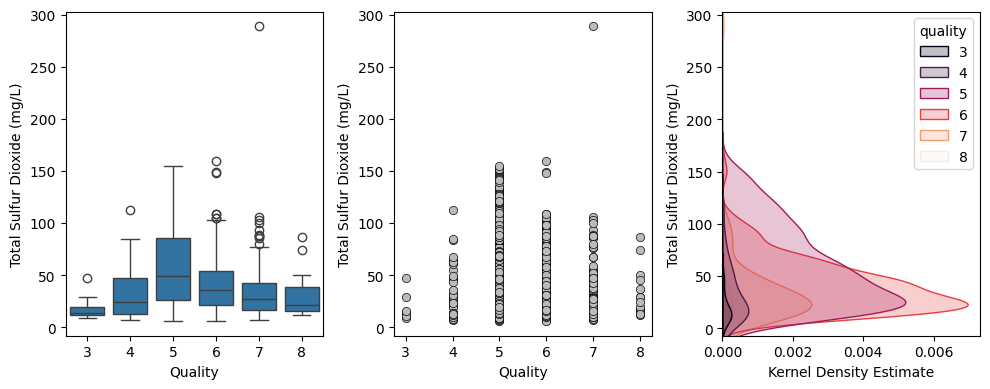

In [ ]:
plot_feature(train_X, 'total sulfur dioxide', train_y, [-7,303])



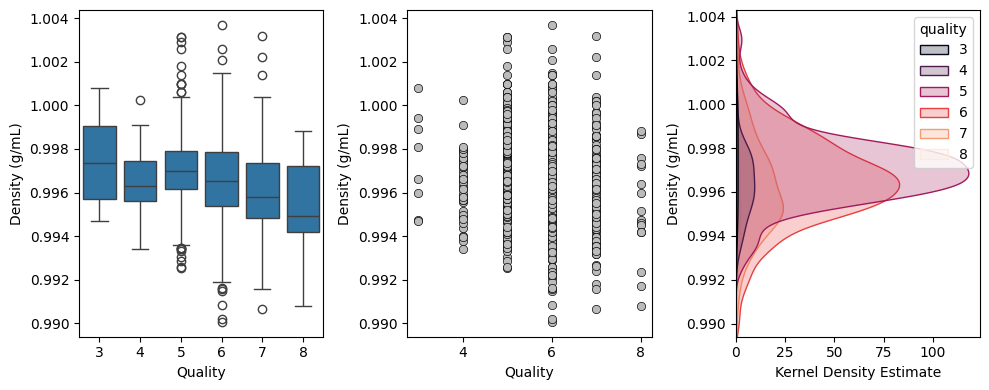

In [ ]:
plot_feature(train_X, 'density', train_y, [0.9894,1.0043])

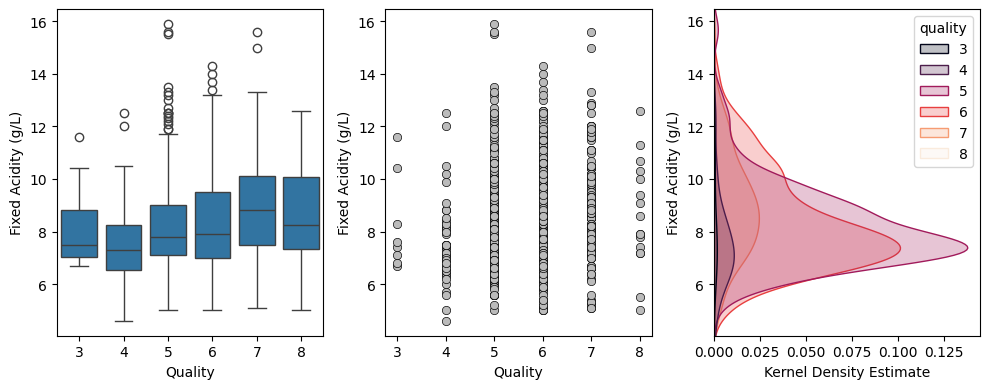

In [ ]:
plot_feature(train_X, 'fixed acidity', train_y, [4.05,16.45])

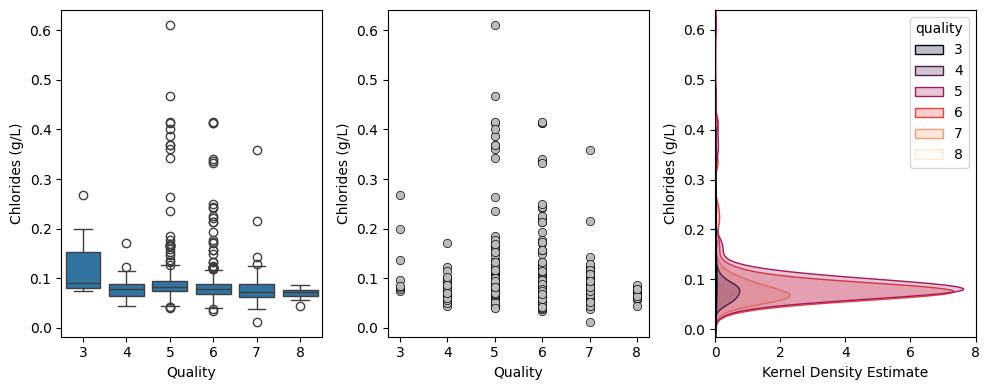

In [ ]:
plot_feature(train_X, 'chlorides', train_y, [-0.015,0.64])

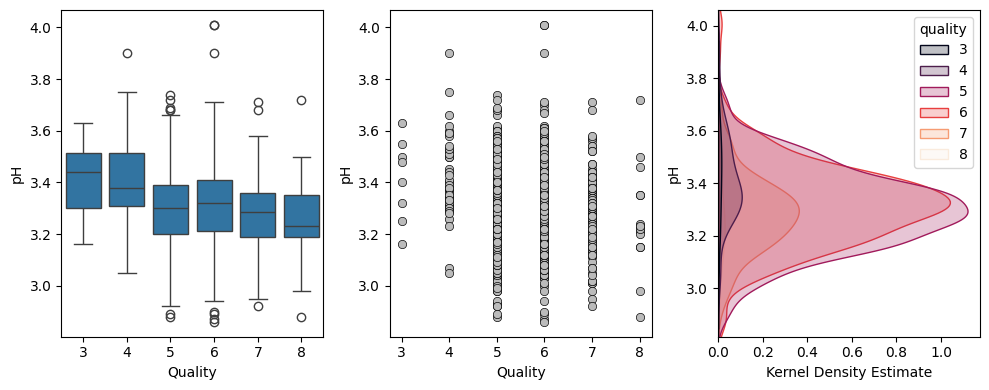

In [ ]:
plot_feature(train_X, 'pH', train_y, [2.815,4.06])

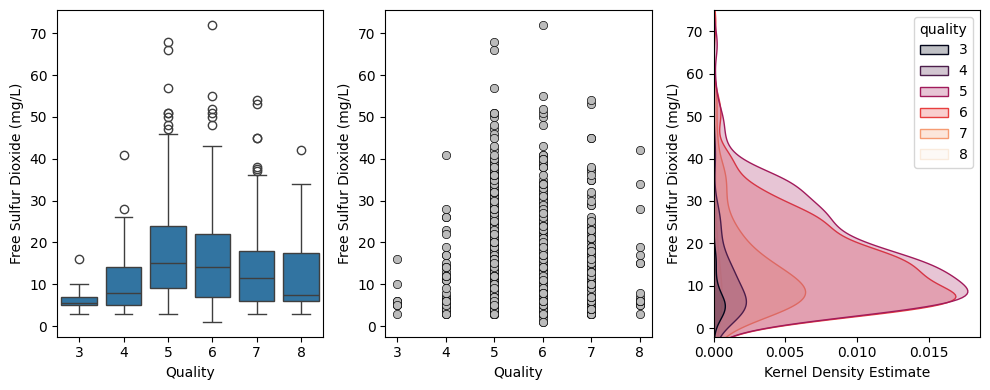

In [ ]:
plot_feature(train_X, 'free sulfur dioxide', train_y, [-2,75])

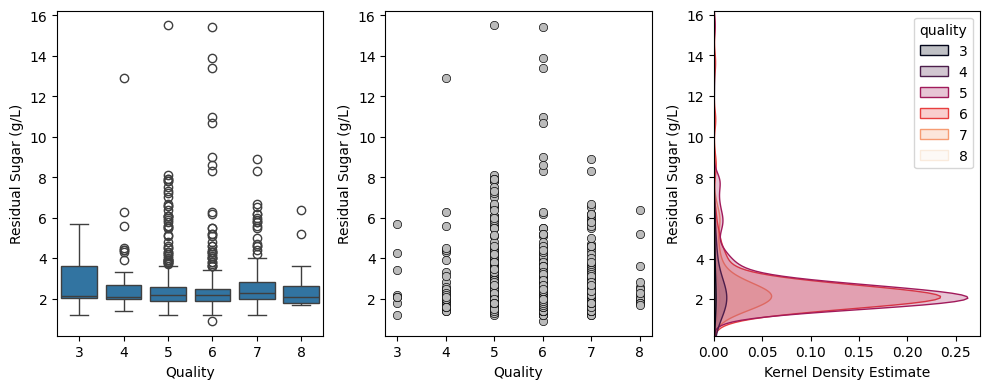

In [ ]:
plot_feature(train_X, 'residual sugar', train_y, [0.2,16.2])

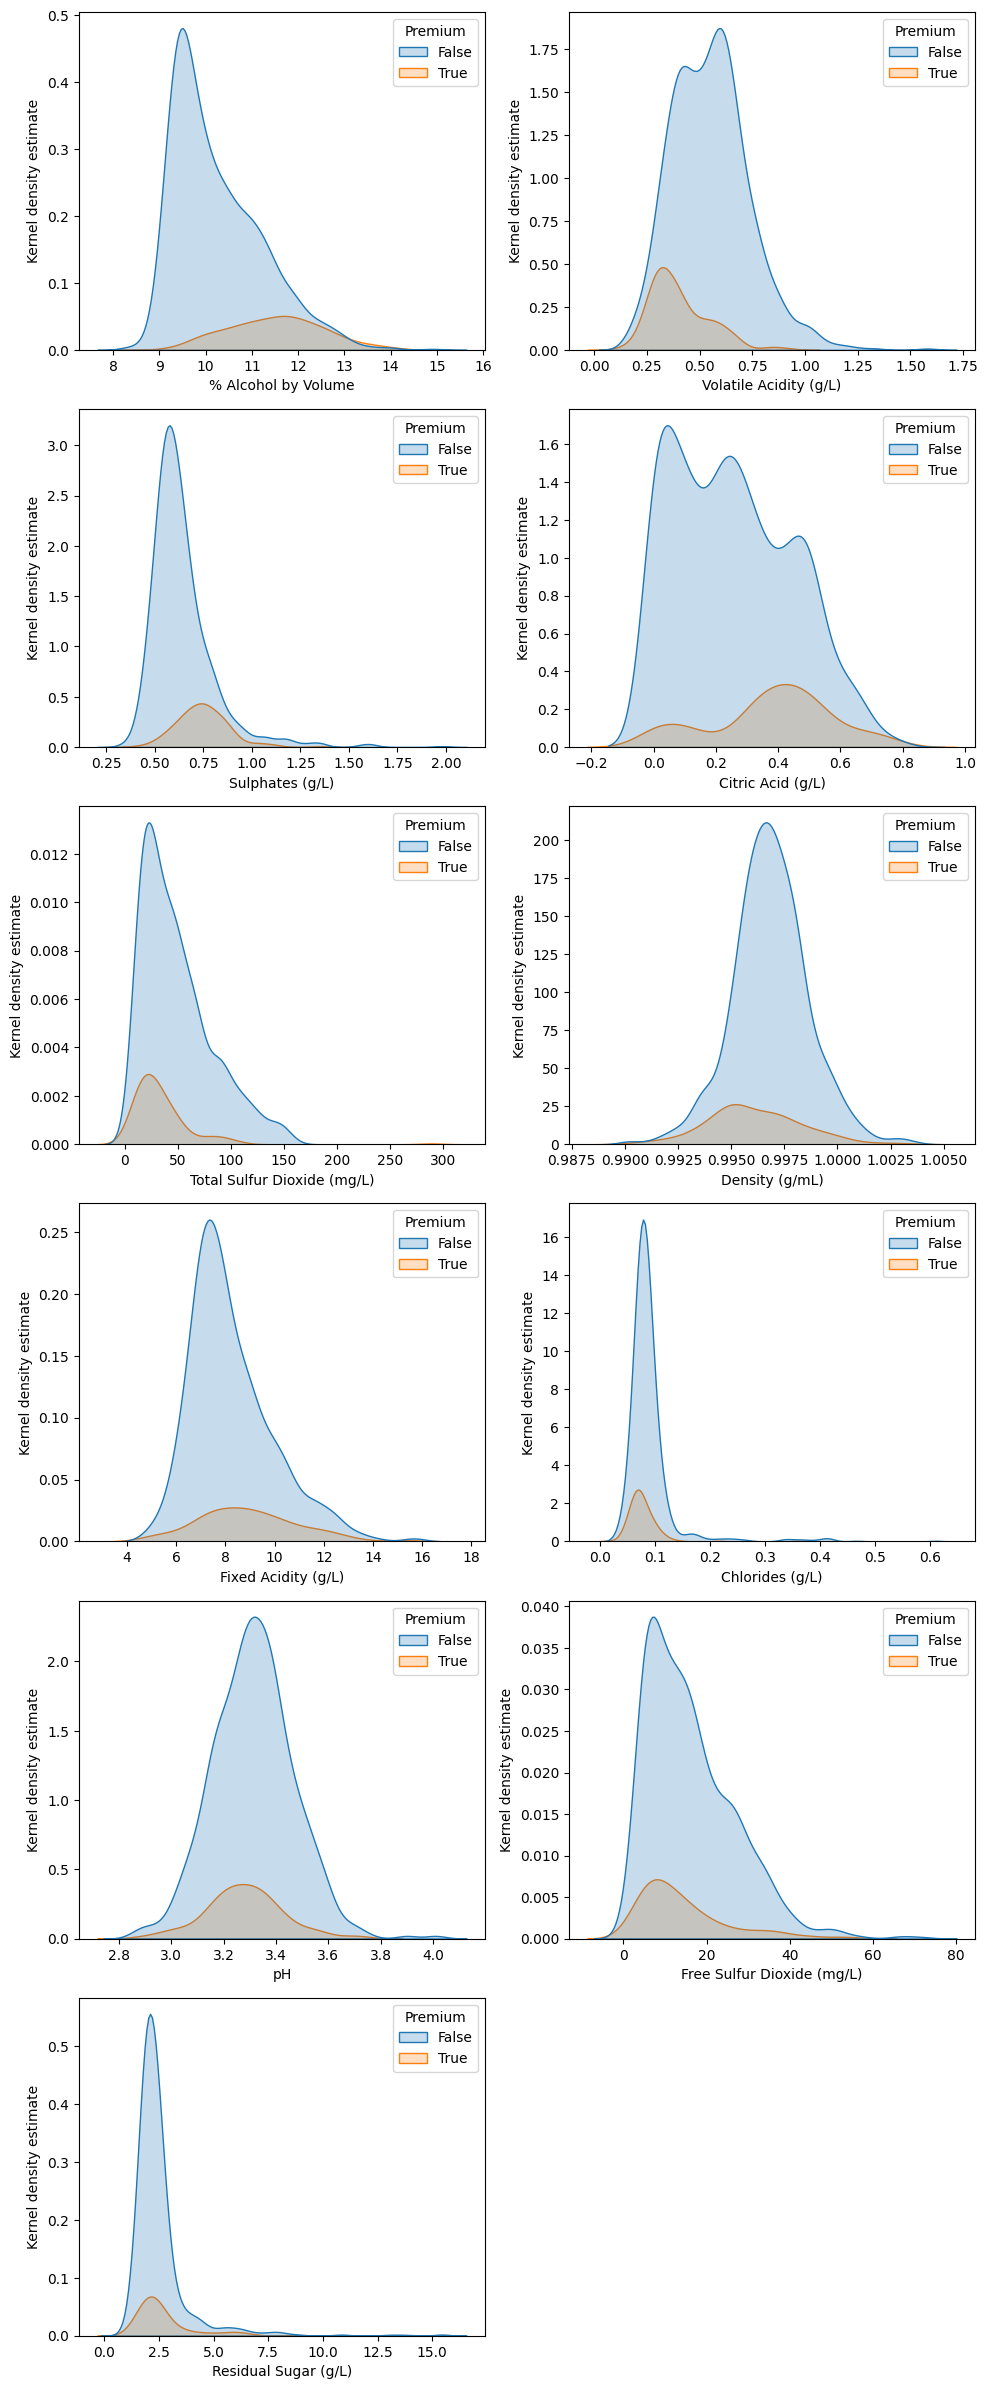

In [ ]:
plot_pnp_densities(train_X, train_y_class)

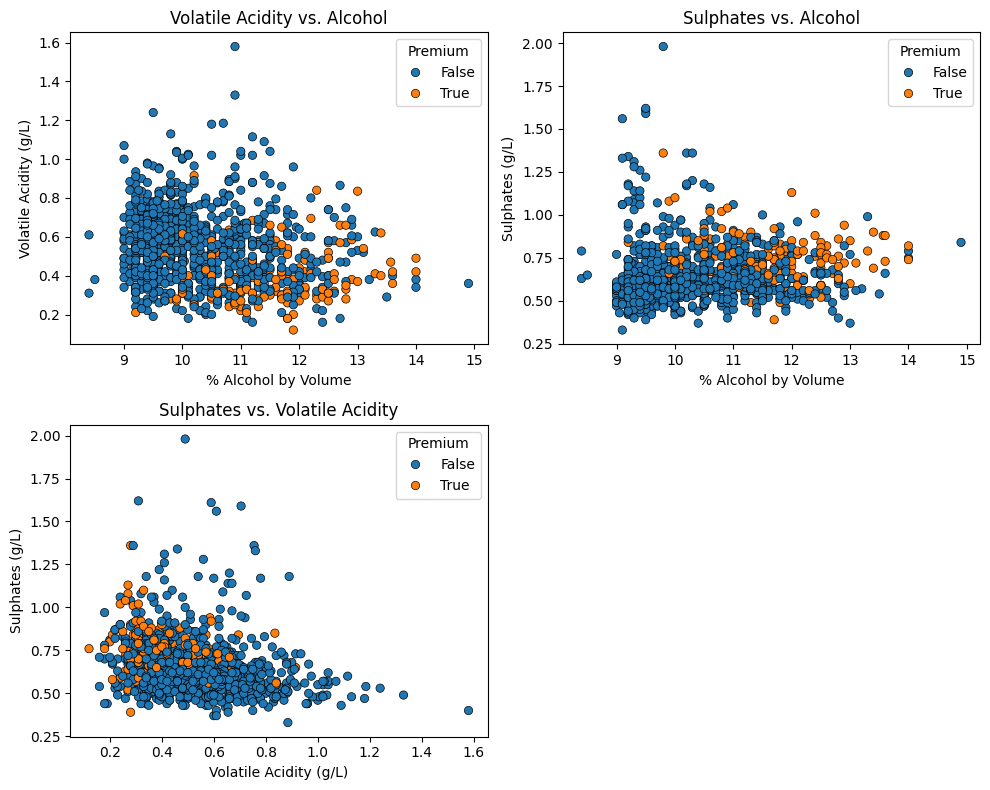

In [ ]:
plot_scatters(train_X, train_y_class)

In [ ]:
# Columns in correlation coefficient magnitude order.  Reused below.
columns = ['alcohol','volatile acidity','sulphates','citric acid',
           'total sulfur dioxide','density','fixed acidity','chlorides',
           'pH','free sulfur dioxide','residual sugar']

lc = LogisticRegression(max_iter=1000)

df = pd.DataFrame()
for i in range(len(columns)):

    scores = cross_validate(lc, train_X[columns[:i+1]], train_y_class, cv=5,
                            scoring=['accuracy', 'precision'],
                            return_train_score=True)

    df = df_append(df, {'index': i,
                        'Number of Factors': i + 1,
                        'Validation Set Accuracy': scores['test_accuracy'].mean(),
                        'Standard Deviation': scores['test_accuracy'].std(),
                        'Mean Precision': scores['test_precision'].mean(),
                        'Training Set Accuracy': scores['train_accuracy'].mean()})

# Record for below.
lc_accuracy = cross_val_score(lc, train_X[columns[:11]], train_y_class, cv=5,
                              scoring='accuracy').mean()
lc_precision = cross_val_score(lc, train_X[columns[:11]], train_y_class, cv=5,
                               scoring='precision').mean()

df

,Number of Factors,Validation Set Accuracy,Standard Deviation,Mean Precision,Training Set Accuracy
0,1,0.853735,0.017978,0.461630,0.859706
1,2,0.868448,0.012191,0.603388,0.867986
2,3,0.870296,0.010120,0.620238,0.870056
3,4,0.871217,0.011876,0.624683,0.873045
4,5,0.873978,0.008320,0.613571,0.873506
5,6,0.873978,0.008320,0.613571,0.873506
6,7,0.873052,0.009362,0.591912,0.875346
7,8,0.874891,0.007803,0.611609,0.876496
8,9,0.875817,0.010330,0.611586,0.875806
9,10,0.875825,0.012115,0.616389,0.877647


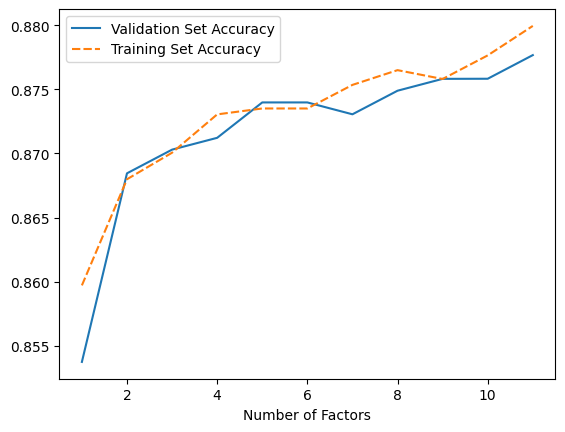

In [ ]:
df = df.set_index('Number of Factors')
txt=sns.lineplot(data=df[['Validation Set Accuracy', 'Training Set Accuracy']])

In [ ]:
# Defaults: n_estimators=100, max_features=3, min_samples_leaf=1
rfc = RandomForestClassifier(n_estimators=500, max_features=5, min_samples_leaf=3,
                             random_state=1)

scores = cross_val_score(rfc, train_X, train_y_class, cv=5, scoring='accuracy')
print('Accuracy:')
print('\tmean:', scores.mean(), 'std:', scores.std())

# Record for below.
rfc_accuracy = scores.mean()

Accuracy:
	mean: 0.8804084048535069 std: 0.014539157535358251


In [ ]:
scores = cross_val_score(rfc, train_X, train_y_class, cv=5, scoring='precision')
print('Precision:')
print('\tmean:', scores.mean(), 'std:', scores.std())

# Record for below.
rfc_precision = scores.mean()

Precision:
	mean: 0.643452380952381 std: 0.09860851614228008


In [ ]:
# Defaults: n_estimators=100, eta=0.3, gamma=0, max_depth=6, subsample=1,
# colsample_bytree=1, lambda=1, alpha=0

xgbc = XGBClassifier(n_estimators=300, eta=0.5, max_depth=4, colsample_bytree=0.7,
                     subsample=0.6, gamma=5, reg_alpha=3, reg_lambda=0,
                     random_state=1)

scores = cross_val_score(xgbc, train_X, train_y_class, cv=5, scoring='accuracy')
print('Accuracy:')
print('\tmean:', scores.mean(), 'std:', scores.std())

# Record for below.
xgbc_accuracy = scores.mean()

Accuracy:
	mean: 0.8730309051705915 std: 0.012358836241417462


In [ ]:
scores = cross_val_score(xgbc, train_X, train_y_class, cv=5, scoring='precision')
print('Precision:')
print('\tmean:', scores.mean(), 'std:', scores.std())

# Record for below.
xgbc_precision = scores.mean()



Precision:
	mean: 0.5854329004329004 std: 0.08743762551515204


In [ ]:
lr = LinearRegression()

df = pd.DataFrame()
for i in range(len(columns)):

    scores = cross_validate(lr, train_X[columns[:i+1]], train_y, cv=5,
                            scoring='neg_root_mean_squared_error', return_train_score=True)

    df = df_append(df, {'index': i,
                        'Number of Factors': i + 1,
                        'Validation Set RMSE': -scores['test_score'].mean(),
                        'Standard Deviation': scores['test_score'].std(),
                        'Training Set RMSE': -scores['train_score'].mean()})

df

,Number of Factors,Validation Set RMSE,Standard Deviation,Training Set RMSE
0,1,0.730419,0.049571,0.731423
1,2,0.680593,0.042068,0.681269
2,3,0.667211,0.047820,0.667050
3,4,0.667405,0.047890,0.667011
4,5,0.664857,0.047772,0.664160
5,6,0.664733,0.047776,0.663989
6,7,0.662131,0.045451,0.660817
7,8,0.660794,0.045748,0.658770
8,9,0.659820,0.045276,0.656852
9,10,0.658257,0.045428,0.655135


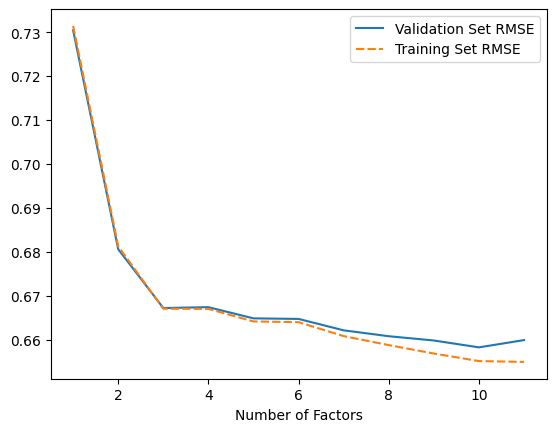

In [ ]:
df = df.set_index('Number of Factors')
txt=sns.lineplot(data=df[['Validation Set RMSE', 'Training Set RMSE']])

In [ ]:
rfr = RandomForestRegressor(n_estimators=800, max_features=5, min_samples_leaf=2,
                            random_state=1)
scores = cross_val_score(rfr, train_X, train_y, cv=5,
                         scoring='neg_root_mean_squared_error')
print('RMSE:')
print('\tmean:', -1*scores.mean(), 'std:', scores.std())

RMSE:
	mean: 0.6396110324807847 std: 0.05036759529684838


In [ ]:
xgbr = XGBRegressor(n_estimators=300, eta=0.03, max_depth=6, colsample_bytree=0.7,
                   subsample=0.9, gamma=2, reg_alpha=0, reg_lambda=1, random_state=1)
scores = cross_val_score(xgbr, train_X.drop(['residual sugar'], axis=1), train_y, cv=5,
                         scoring='neg_root_mean_squared_error')
print('RMSE:')
print('\tmean:', -1*scores.mean(), 'std:', scores.std())

RMSE:
	mean: 0.6384587029990028 std: 0.04800771066789848


In [ ]:
pca, X_pca, loadings = apply_pca(train_X, standardize=True)
print(loadings)

                           PC1       PC2       PC3       PC4       PC5  \
fixed acidity         0.492681 -0.083352 -0.117009 -0.214711 -0.099557   
volatile acidity     -0.245075  0.276560 -0.444556  0.037276  0.238487   
citric acid           0.469813 -0.147077  0.218293 -0.064526 -0.065048   
residual sugar        0.136546  0.235108  0.129005 -0.413512  0.732727   
chlorides             0.188761  0.112739 -0.142626  0.656213  0.321114   
free sulfur dioxide  -0.043716  0.493913  0.462789  0.015762 -0.156423   
total sulfur dioxide  0.025806  0.577603  0.331713  0.005040 -0.164897   
density               0.392450  0.260494 -0.315954 -0.184462  0.131038   
pH                   -0.446945 -0.006007  0.065564 -0.020119  0.231217   
sulphates             0.237557 -0.061368  0.269936  0.542532  0.245699   
alcohol              -0.097040 -0.421563  0.450383 -0.133010  0.326065   

                           PC6       PC7       PC8       PC9      PC10  \
fixed acidity         0.053935 -0.369

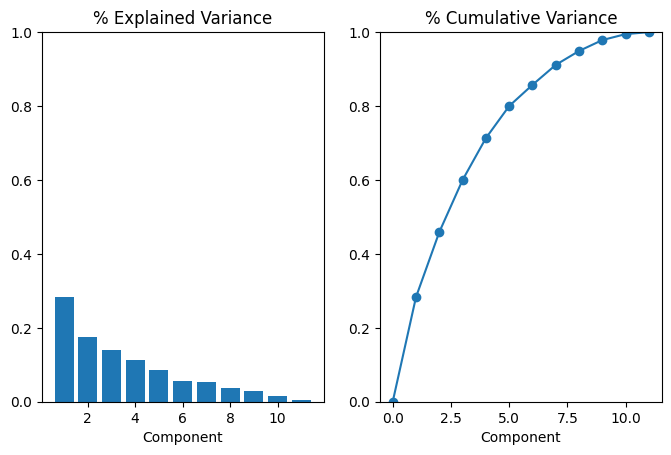

In [ ]:
txt = plot_variance(pca)

In [ ]:
pca = PCA()
train_X_pca = pca.fit_transform(train_X_standard)
components = ['PC' + str(i) for i in range(1,train_X_pca.shape[1] + 1)]
train_X_pca = pd.DataFrame(train_X_pca, columns=components)
train_X_pca = train_X_pca.drop(['PC4','PC11'], axis=1)
components[10:11] = []
components[3:4] = []

scores = cross_val_score(lr, train_X_pca, train_y, cv=5,
                         scoring='neg_root_mean_squared_error')
print('factors:', i + 1, 'mean:', -1*scores.mean(), 'std:', scores.std())

factors: 11 mean: 0.6594368071979433 std: 0.04579963527393915


In [ ]:
pca = PCA()
train_X_pca = pca.fit_transform(train_X_standard)
components = ['PC' + str(i) for i in range(1,train_X_pca.shape[1] + 1)]
train_X_pca = pd.DataFrame(train_X_pca, columns=components)

# hparams = {
#     'n_estimators': [300],
#     'eta': [0.02],
#     'max_depth': [7],
#     'colsample_bytree': [0.9],
#     'subsample': [0.4],
#     'gamma': [1],
#     'alpha': [1],
#     'lambda': [0],
# }
# xgb = XGBRegressor(random_state=1)
# search = GridSearchCV(estimator=xgb, param_grid=hparams,
#                       scoring='neg_root_mean_squared_error',
#                       verbose=1)
# search.fit(train_X_pca, train_y)
# print('best_params', search.best_params_)
# print('best_score', search.best_score_)

xgbp = XGBRegressor(n_estimators=300, eta=0.02, max_depth=7, colsample_bytree=0.9,
                   subsample=0.4, gamma=1, alpha=1, reg_lambda=0, random_state=1)
scores = cross_val_score(xgbp, train_X_pca, train_y, cv=5,
                         scoring='neg_root_mean_squared_error')
print('mean:', -1*scores.mean(), 'std:', scores.std())

mean: 0.6505078571630732 std: 0.05358959710862532


Polynomial:
	mean: 0.7302670922001627 std: 0.050928914333694175
Linear:
	mean: 0.730419082540344 std: 0.04957051300081766


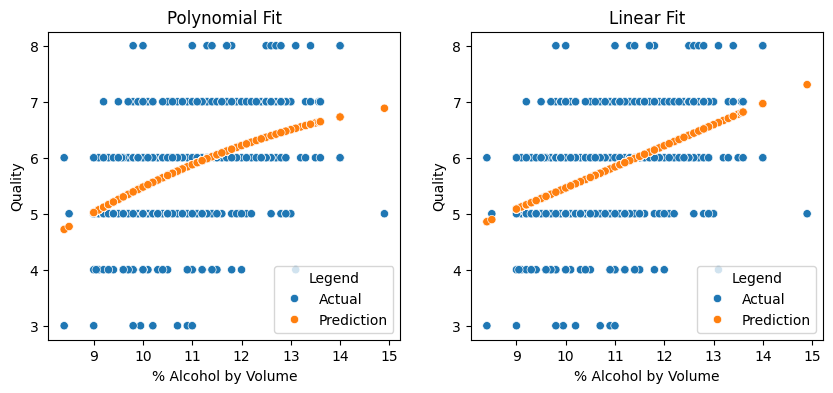

In [ ]:
pf = PolynomialFeatures(degree=2, include_bias=False)
alc_poly = pf.fit_transform(train_X[['alcohol']])
scores = cross_val_score(lr, alc_poly, train_y, cv=5,
                         scoring='neg_root_mean_squared_error')
print('Polynomial:')
print('\tmean:', -1*scores.mean(), 'std:', scores.std())
lr.fit(alc_poly, train_y)

df = pd.DataFrame({'alcohol': train_X['alcohol'], 'Actual': train_y,
                   'Prediction': lr.predict(alc_poly)})
df = df.melt('alcohol', var_name='Legend')

scores = cross_val_score(lr, train_X[['alcohol']], train_y, cv=5,
                         scoring='neg_root_mean_squared_error')
print('Linear:')
print('\tmean:', -1*scores.mean(), 'std:', scores.std())
lr.fit(train_X[['alcohol']], train_y)

df2 = pd.DataFrame({'alcohol': train_X['alcohol'], 'Actual': train_y,
                   'Prediction': lr.predict(train_X[['alcohol']])})
df2 = df2.melt('alcohol', var_name='Legend')

fig, sub_axes = plt.subplots(1,2,figsize=(10,4))
axes = sns.scatterplot(data=df, x='alcohol', y='value', hue='Legend',
                       ax=sub_axes[0])
txt = axes.set(title='Polynomial Fit', xlabel='% Alcohol by Volume',
               ylabel='Quality')
axes = sns.scatterplot(data=df2, x='alcohol', y='value', hue='Legend',
                       ax=sub_axes[1])
txt = axes.set(title='Linear Fit', xlabel='% Alcohol by Volume',
               ylabel='Quality')

In [ ]:
tX = train_X.copy()
tX['alcohol squared'] = tX['alcohol']**2
columns_poly = ['alcohol','alcohol squared','volatile acidity','sulphates',
                'citric acid','total sulfur dioxide', 'density','fixed acidity',
                'chlorides','pH','free sulfur dioxide','residual sugar']

df = pd.DataFrame()
for i in range(len(columns_poly)):

    scores = cross_validate(lr, tX[columns_poly[:i+1]], train_y, cv=5,
                             scoring='neg_root_mean_squared_error',
                            return_train_score=True)

    df = df_append(df, {'index': i,
                        'Number of Factors': i + 1,
                        'Validation Set RMSE': -scores['test_score'].mean(),
                        'Standard Deviation': scores['test_score'].std(),
                        'Training Set RMSE': -scores['train_score'].mean()})

df

,Number of Factors,Validation Set RMSE,Standard Deviation,Training Set RMSE
0,1,0.730419,0.049571,0.731423
1,2,0.730267,0.050929,0.730252
2,3,0.680499,0.043151,0.680148
3,4,0.667119,0.048498,0.665961
4,5,0.667312,0.048560,0.665928
5,6,0.665263,0.048099,0.663551
6,7,0.665241,0.048030,0.663425
7,8,0.662752,0.045640,0.660186
8,9,0.661557,0.045737,0.658300
9,10,0.660605,0.045426,0.656399


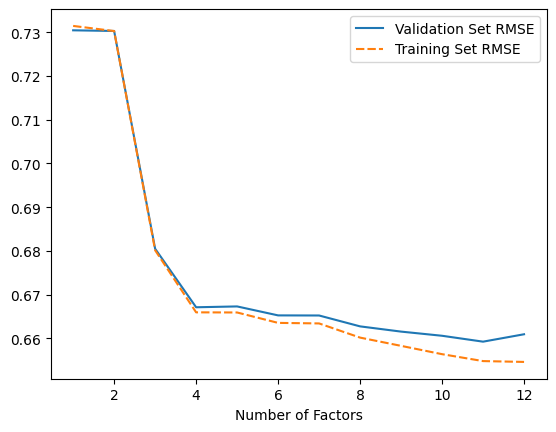

In [ ]:


df = df.set_index('Number of Factors')
txt=sns.lineplot(data=df[['Validation Set RMSE', 'Training Set RMSE']])



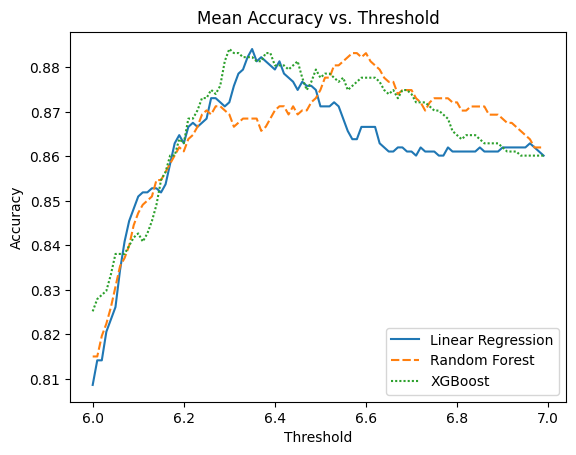

In [ ]:
threshold, linear_accuracy = accuracy_by_threshold(lr, train_set_X,
                                                   train_set_y, validation_set_X,
                                                   validation_set_y)

threshold, rf_accuracy = accuracy_by_threshold(rfr, train_set_X,
                                               train_set_y, validation_set_X,
                                               validation_set_y)

threshold, xgb_accuracy = accuracy_by_threshold(xgbr, train_set_X,
                                                train_set_y, validation_set_X,
                                                validation_set_y,
                                                drop_columns=['residual sugar'])

df = pd.DataFrame({'Linear Regression': linear_accuracy[600:700],
                   'Random Forest': rf_accuracy[600:700],
                   'XGBoost': xgb_accuracy[600:700]},
                  index=threshold[600:700])
axes = sns.lineplot(data=df)
txt = axes.set(title='Mean Accuracy vs. Threshold', xlabel='Threshold',
               ylabel='Accuracy')

In [ ]:
lr_max_i, lr_max_accuracy = get_max_with_index(linear_accuracy)
rfr_max_i, rfr_max_accuracy = get_max_with_index(rf_accuracy)
xgbr_max_i, xgbr_max_accuracy = get_max_with_index(xgb_accuracy)

accuracy_df = pd.DataFrame({
    'Threshold': ['n/a', 'n/a', 'n/a', lr_max_i/100, rfr_max_i/100,
                  xgbr_max_i/100],
    'Accuracy': [lc_accuracy, rfc_accuracy, xgbc_accuracy, lr_max_accuracy,
                 rfr_max_accuracy, xgbr_max_accuracy]
}, index=['Logistic Regression', 'Random Forest Classification',
                  'XGBoost Classification', 'Linear Regression',
                  'Random Forest Regression', 'XGBoost Regression']
)
accuracy_df.sort_values(by='Accuracy', ascending=False)

,Threshold,Accuracy
XGBoost Regression,6.3,0.884116
Linear Regression,6.35,0.884095
Random Forest Regression,6.57,0.883178
Random Forest Classification,n/a,0.880408
Logistic Regression,n/a,0.877669
XGBoost Classification,n/a,0.873031


In [ ]:

lr_tpr = get_threshold_precision_recall(lr, train_set_X, train_set_y,
                                        validation_set_X, validation_set_y,
                                        drop_columns=['residual sugar'])

lr_threshold = lr_tpr['threshold_mean']
lr_precision_mean = lr_tpr['precision_mean']

df_from_tpr(lr_tpr)



,Mean,Standard Deviation
Threshold,6.612169,0.089985
Precision,0.586111,0.141203
Recall,0.132157,0.060520


In [ ]:
rfr_tpr = get_threshold_precision_recall(rfr, train_set_X, train_set_y,
                                         validation_set_X, validation_set_y)
rfr_threshold = rfr_tpr['threshold_mean']
rfr_precision_mean = rfr_tpr['precision_mean']

df_from_tpr(rfr_tpr)



,Mean,Standard Deviation
Threshold,6.716525,0.117733
Precision,0.708889,0.084444
Recall,0.152617,0.064887


In [ ]:


xgbr_tpr = get_threshold_precision_recall(xgbr, train_set_X, train_set_y,
                                          validation_set_X, validation_set_y,
                                          drop_columns=['residual sugar'])
xgbr_threshold = xgbr_tpr['threshold_mean']
xgbr_precision_mean = xgbr_tpr['precision_mean']

df_from_tpr(xgbr_tpr)



,Mean,Standard Deviation
Threshold,6.640766,0.060236
Precision,0.755556,0.167037
Recall,0.165332,0.050306


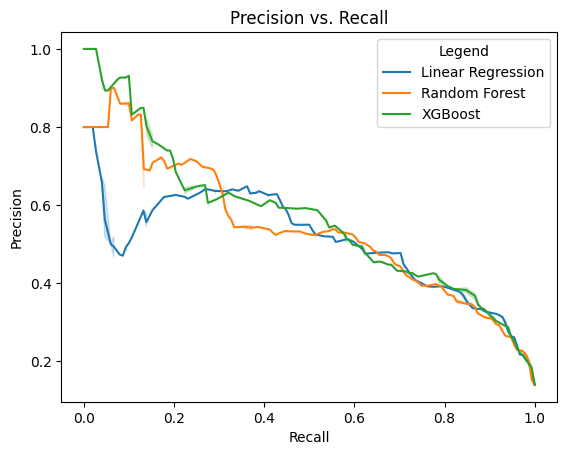

In [ ]:
precisions = []
recalls = []
for i in range(5):
    precision = []
    recall = []
    t_X = train_set_X[i]
    t_y = train_set_y[i]
    v_X = validation_set_X[i]
    v_y = validation_set_y[i]
    lr.fit(t_X, t_y)
    y_hat = lr.predict(v_X)
    for j in range(0,1000):
        if np.sum(y_hat >= j/100) > 0:
            p = np.sum((y_hat >= j/100) & (v_y >= 7))/np.sum(y_hat >= j/100)
        else:
            p = last_p
        last_p = p
        precision.append(p)
        r = np.sum((y_hat >= j/100) & (v_y >= 7))/np.sum(v_y >= 7)
        recall.append(r)
    precisions.append(precision)
    recalls.append(recall)
lr_precision = []
lr_recall = []

for j in range(0,1000):
    sum = 0
    for i in range(5):
        sum += precisions[i][j]
    lr_precision.append(sum/5)
    sum = 0
    for i in range(5):
        sum += recalls[i][j]
    lr_recall.append(sum/5)

# Calculate precision and recall values for Random Forest.
precisions = []
recalls = []
for i in range(5):
    precision = []
    recall = []
    t_X = train_set_X[i]
    t_y = train_set_y[i]
    v_X = validation_set_X[i]
    v_y = validation_set_y[i]
    rfr.fit(t_X, t_y)
    y_hat = rfr.predict(v_X)
    for j in range(0,1000):
        if np.sum(y_hat >= j/100) > 0:
            p = np.sum((y_hat >= j/100) & (v_y >= 7))/np.sum(y_hat >= j/100)
        else:
            p = last_p
        last_p = p
        precision.append(p)
        r = np.sum((y_hat >= j/100) & (v_y >= 7))/np.sum(v_y >= 7)
        recall.append(r)
    precisions.append(precision)
    recalls.append(recall)
rfr_precision = []
rfr_recall = []

for j in range(0,1000):
    sum = 0
    for i in range(5):
        sum += precisions[i][j]
    rfr_precision.append(sum/5)
    sum = 0
    for i in range(5):
        sum += recalls[i][j]
    rfr_recall.append(sum/5)

# Calculate precision and recall values for XGBoost.
precisions = []
recalls = []
for i in range(5):
    precision = []
    recall = []
    t_X = train_set_X[i].drop(['residual sugar'], axis=1)
    t_y = train_set_y[i]
    v_X = validation_set_X[i].drop(['residual sugar'], axis=1)
    v_y = validation_set_y[i]
    xgbr.fit(t_X, t_y)
    y_hat = xgbr.predict(v_X)
    for j in range(0,1000):
        if np.sum(y_hat >= j/100) > 0:
            p = np.sum((y_hat >= j/100) & (v_y >= 7))/np.sum(y_hat >= j/100)
        else:
            p = last_p
        last_p = p
        precision.append(p)
        r = np.sum((y_hat >= j/100) & (v_y >= 7))/np.sum(v_y >= 7)
        recall.append(r)
    precisions.append(precision)
    recalls.append(recall)
xgbr_precision = []
xgbr_recall = []

for j in range(0,1000):
    sum = 0
    for i in range(5):
        sum += precisions[i][j]
    xgbr_precision.append(sum/5)
    sum = 0
    for i in range(5):
        sum += recalls[i][j]
    xgbr_recall.append(sum/5)

df_lr = pd.DataFrame({'Recall': lr_recall, 'Precision': lr_precision})
df_lr['Legend'] = 'Linear Regression'
df_rfr = pd.DataFrame({'Recall': rfr_recall, 'Precision': rfr_precision})
df_rfr['Legend'] = 'Random Forest'
df_xgbr = pd.DataFrame({'Recall': xgbr_recall, 'Precision': xgbr_precision})
df_xgbr['Legend'] = 'XGBoost'
df = pd.concat([df_lr, df_rfr, df_xgbr])
axes = sns.lineplot(data=df, x='Recall', y='Precision', hue='Legend')
txt = axes.set(title='Precision vs. Recall')

In [ ]:
precision_df = pd.DataFrame({
    'Threshold': ['n/a', 'n/a', 'n/a', lr_threshold, rfr_threshold,
                  xgbr_threshold],
    'Precision': [lc_precision, rfc_precision, xgbc_precision,
                  lr_precision_mean, rfr_precision_mean, xgbr_precision_mean]
}, index=['Logistic Regression', 'Random Forest Classification',
                  'XGBoost Classification', 'Linear Regression',
                  'Random Forest Regression', 'XGBoost Regression']
)
precision_df.sort_values(by='Precision', ascending=False)

,Threshold,Precision
XGBoost Regression,6.640766,0.755556
Random Forest Regression,6.716525,0.708889
Random Forest Classification,n/a,0.643452
Logistic Regression,n/a,0.624477
Linear Regression,6.612169,0.586111
XGBoost Classification,n/a,0.585433


In [ ]:
lc_precision, lc_results = get_classification_results(lc, train_X, train_y,
                                                      test_X, test_y)

rfc_precision, rfc_results = get_classification_results(rfc, train_X, train_y,
                                                        test_X, test_y)

xgbc_precision, xgbc_results = get_classification_results(xgbc, train_X, train_y,
                                                          test_X, test_y)

lr_precision, lr_results = get_regression_results(lr, train_X, train_y,
                                                  test_X, test_y, lr_threshold,
                                                  drop_columns=['residual sugar'])

rfr_precision, rfr_results = get_regression_results(rfr, train_X, train_y,
                                                    test_X, test_y, rfr_threshold)

xgbr_precision, xgbr_results = get_regression_results(xgbr, train_X, train_y,
                                                      test_X, test_y, xgbr_threshold,
                                                      drop_columns=['residual sugar'])

df = pd.DataFrame()
df = df_append(df, {'index': 'Logistic Regression (Classification)',
                    'Precision': lc_precision})
df = df_append(df, {'index': 'Random Forest Classification',
                    'Precision': rfc_precision})
df = df_append(df, {'index': 'XGBoost Classification',
                    'Precision': xgbc_precision})
df = df_append(df, {'index': 'Linear Regression',
                    'Precision': lr_precision})
df = df_append(df, {'index': 'Random Forest Regression',
                    'Precision': rfr_precision})
df = df_append(df, {'index': 'XGBoost Regression',
                    'Precision': xgbr_precision})

df.sort_values(by='Precision', ascending=False)

,Precision
Random Forest Regression,0.800000
XGBoost Regression,0.727273
Random Forest Classification,0.590909
Logistic Regression (Classification),0.473684
XGBoost Classification,0.454545
Linear Regression,0.400000


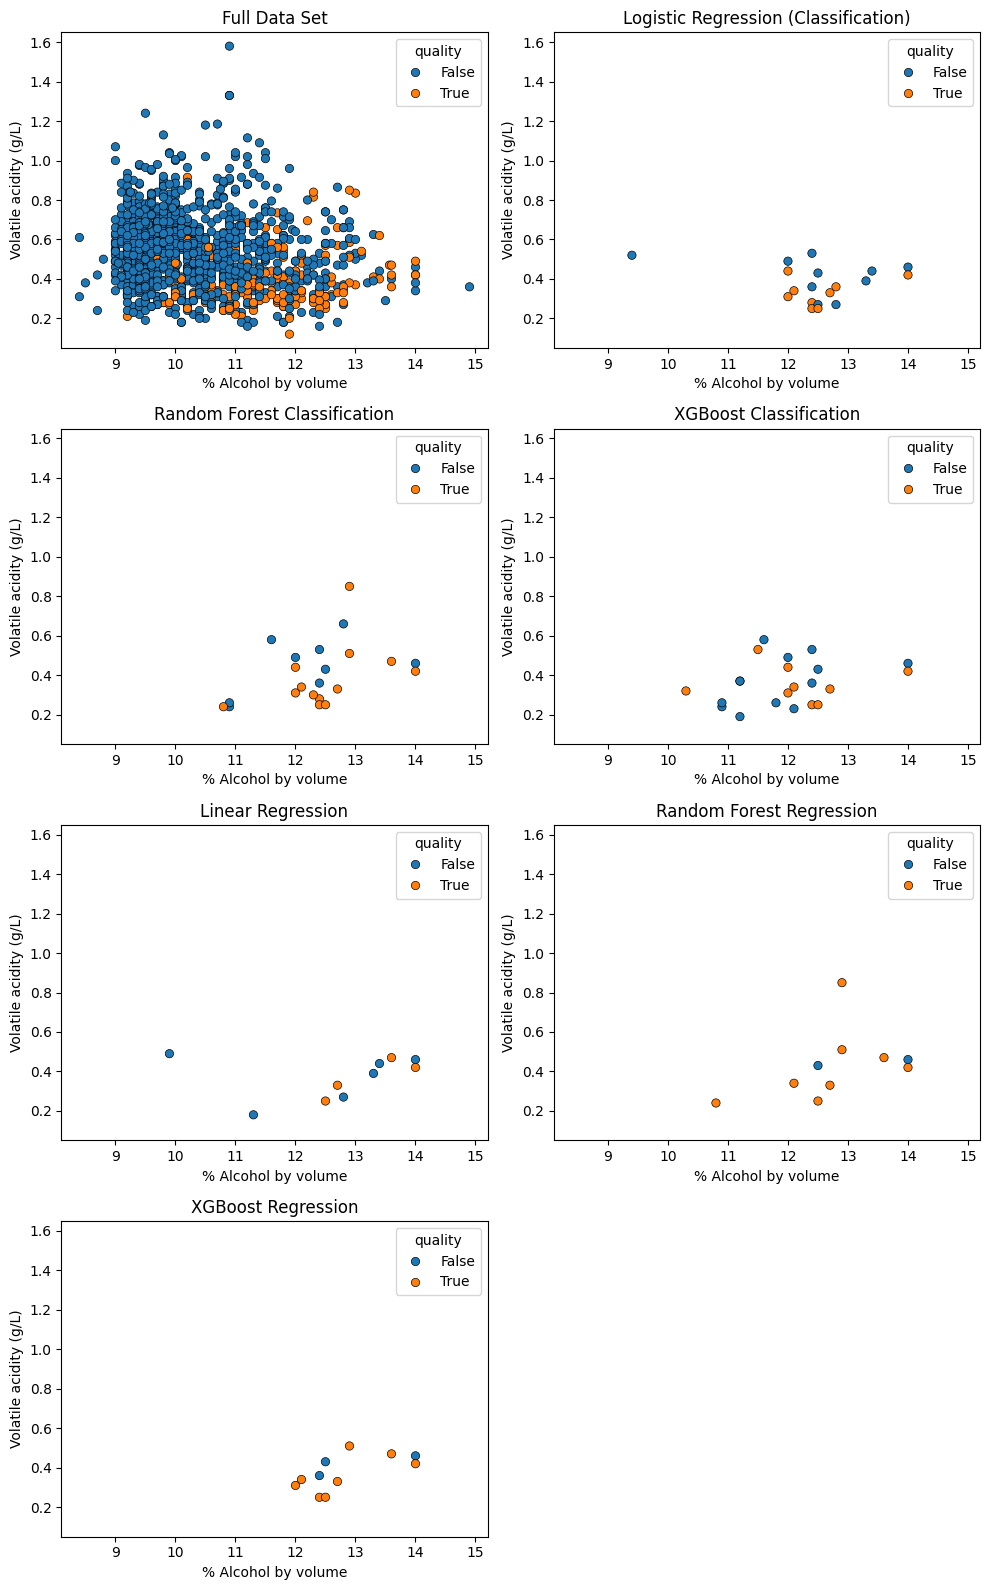

In [ ]:
final_results = {
    'Full Data Set': dataset,
    'Logistic Regression (Classification)': lc_results,
    'Random Forest Classification': rfc_results,
    'XGBoost Classification': xgbc_results,
    'Linear Regression': lr_results,
    'Random Forest Regression': rfr_results,
    'XGBoost Regression': xgbr_results,
}

plot_final_results(final_results)

In [ ]:
lc_precisions = []
lc_results = pd.DataFrame()
for i in range(100):
    train_X, test_X, train_y, test_y = \
        train_test_split(X, y, test_size=0.2, random_state=i)
    lc.fit(train_X, train_y >= 7)
    y_hat = lc.predict(test_X)
    precision = np.sum(y_hat & (test_y >= 7))/np.sum(y_hat)
    lc_precisions.append(precision)
    results = pd.concat([test_X[y_hat == 1], test_y[y_hat == 1]], axis=1)
    lc_results = pd.concat([lc_results, results])
lc_results.drop_duplicates(inplace=True)

rfc_precisions = []
rfc_results = pd.DataFrame()
for i in range(100):
    train_X, test_X, train_y, test_y = \
        train_test_split(X, y, test_size=0.2, random_state=i)
    rfc.fit(train_X, train_y >= 7)
    y_hat = rfc.predict(test_X)
    precision = np.sum(y_hat & (test_y >= 7))/np.sum(y_hat)
    rfc_precisions.append(precision)
    results = pd.concat([test_X[y_hat == 1], test_y[y_hat == 1]], axis=1)
    rfc_results = pd.concat([rfc_results, results])
rfc_results.drop_duplicates(inplace=True)

xgbc_precisions = []
xgbc_results = pd.DataFrame()
for i in range(100):
    train_X, test_X, train_y, test_y = \
        train_test_split(X, y, test_size=0.2, random_state=i)
    xgbc.fit(train_X, train_y >= 7)
    y_hat = xgbc.predict(test_X)
    precision = np.sum(y_hat & (test_y >= 7))/np.sum(y_hat)
    xgbc_precisions.append(precision)
    results = pd.concat([test_X[y_hat == 1], test_y[y_hat == 1]], axis=1)
    xgbc_results = pd.concat([xgbc_results, results])
xgbc_results.drop_duplicates(inplace=True)

lr_precisions = []
lr_results = pd.DataFrame()
for i in range(100):
    train_X, test_X, train_y, test_y = \
        train_test_split(X, y, test_size=0.2, random_state=i)
    train_X = train_X.drop(['residual sugar'], axis=1)
    test_X = test_X.drop(['residual sugar'], axis=1)
    lr.fit(train_X, train_y)
    y_hat = lr.predict(test_X)
    precision = np.sum((y_hat >= lr_threshold) & (test_y >= 7)) \
        /np.sum(y_hat >= lr_threshold)
    lr_precisions.append(precision)
    results = pd.concat([test_X[y_hat >= lr_threshold],
                         test_y[y_hat >= lr_threshold]], axis=1)
    lr_results = pd.concat([lr_results, results])
lr_results.drop_duplicates(inplace=True)

rfr_precisions = []
rfr_results = pd.DataFrame()
for i in range(100):
    train_X, test_X, train_y, test_y = \
        train_test_split(X, y, test_size=0.2, random_state=i)
    rfr.fit(train_X, train_y)
    y_hat = rfr.predict(test_X)
    precision = np.sum((y_hat >= rfr_threshold) & (test_y >= 7)) \
        /np.sum(y_hat >= rfr_threshold)
    rfr_precisions.append(precision)
    results = pd.concat([test_X[y_hat >= rfr_threshold],
                         test_y[y_hat >= rfr_threshold]], axis=1)
    rfr_results = pd.concat([rfr_results, results])
rfr_results.drop_duplicates(inplace=True)

xgbr_precisions = []
xgbr_results = pd.DataFrame()
for i in range(100):
    train_X, test_X, train_y, test_y = \
        train_test_split(X, y, test_size=0.2, random_state=i)
    train_X = train_X.drop(['residual sugar'], axis=1)
    test_X = test_X.drop(['residual sugar'], axis=1)
    rfr.fit(train_X, train_y)
    y_hat = rfr.predict(test_X)
    precision = np.sum((y_hat >= xgbr_threshold) & (test_y >= 7)) \
        /np.sum(y_hat >= xgbr_threshold)
    xgbr_precisions.append(precision)
    results = pd.concat([test_X[y_hat >= xgbr_threshold],
                         test_y[y_hat >= xgbr_threshold]], axis=1)
    xgbr_results = pd.concat([xgbr_results, results])
xgbr_results.drop_duplicates(inplace=True)

df = pd.DataFrame()
df = df_append(df, {'index': 'Logistic Regression (Classification)',
                    'Precision Mean': np.mean(lc_precisions),
                    '95% Min': np.mean(lc_precisions) \
                        - 1.9842*np.std(lc_precisions)/10,
                    '95% Max': np.mean(lc_precisions) \
                        + 1.9842*np.std(lc_precisions)/10})
df = df_append(df, {'index': 'Random Forest Classification',
                    'Precision Mean': np.mean(rfc_precisions),
                    '95% Min': np.mean(rfc_precisions) \
                        - 1.9842*np.std(rfc_precisions)/10,
                    '95% Max': np.mean(rfc_precisions) \
                        + 1.9842*np.std(rfc_precisions)/10})
df = df_append(df, {'index': 'XGBoost Classification',
                    'Precision Mean': np.mean(xgbc_precisions),
                    '95% Min': np.mean(xgbc_precisions) \
                        - 1.9842*np.std(xgbc_precisions)/10,
                    '95% Max': np.mean(xgbc_precisions) \
                        + 1.9842*np.std(xgbc_precisions)/10})
df = df_append(df, {'index': 'Linear Regression',
                    'Precision Mean': np.mean(lr_precisions),
                    '95% Min': np.mean(lr_precisions) \
                        - 1.9842*np.std(lr_precisions)/10,
                    '95% Max': np.mean(lr_precisions) \
                        + 1.9842*np.std(lr_precisions)/10})
df = df_append(df, {'index': 'Random Forest Regression',
                    'Precision Mean': np.mean(rfr_precisions),
                    '95% Min': np.mean(rfr_precisions) \
                        - 1.9842*np.std(rfr_precisions)/10,
                    '95% Max': np.mean(rfr_precisions) \
                        + 1.9842*np.std(rfr_precisions)/10})
df = df_append(df, {'index': 'XGBoost Regression',
                    'Precision Mean': np.mean(xgbr_precisions),
                    '95% Min': np.mean(xgbr_precisions) \
                        - 1.9842*np.std(xgbr_precisions)/10,
                    '95% Max': np.mean(xgbr_precisions) \
                        + 1.9842*np.std(xgbr_precisions)/10})
df.sort_values('Precision Mean', ascending=False)

,Precision Mean,95% Min,95% Max
Random Forest Regression,0.780939,0.748992,0.812886
XGBoost Regression,0.720464,0.694014,0.746914
Random Forest Classification,0.638218,0.618830,0.657606
Linear Regression,0.622092,0.585997,0.658188
Logistic Regression (Classification),0.603807,0.582485,0.625128
XGBoost Classification,0.569966,0.550664,0.589267


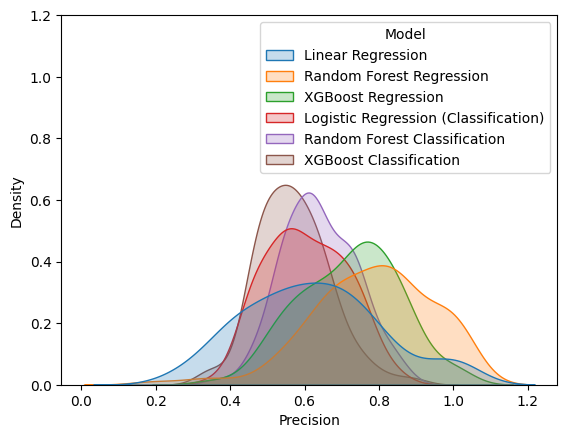

In [ ]:
lc_df = pd.DataFrame({'Precision': lc_precisions, 'Model': 'Logistic Regression (Classification)'})
rfc_df = pd.DataFrame({'Precision': rfc_precisions, 'Model': 'Random Forest Classification'})
xgbc_df = pd.DataFrame({'Precision': xgbc_precisions, 'Model': 'XGBoost Classification'})
lr_df = pd.DataFrame({'Precision': lr_precisions, 'Model': 'Linear Regression'})
rfr_df = pd.DataFrame({'Precision': rfr_precisions, 'Model': 'Random Forest Regression'})
xgbr_df = pd.DataFrame({'Precision': xgbr_precisions, 'Model': 'XGBoost Regression'})
df = pd.concat([lr_df, rfr_df, xgbr_df, lc_df, rfc_df, xgbc_df])
axes = sns.kdeplot(data=df, x='Precision', hue='Model', fill=True)
txt = axes.set(ylim=[-0.0,1.2])

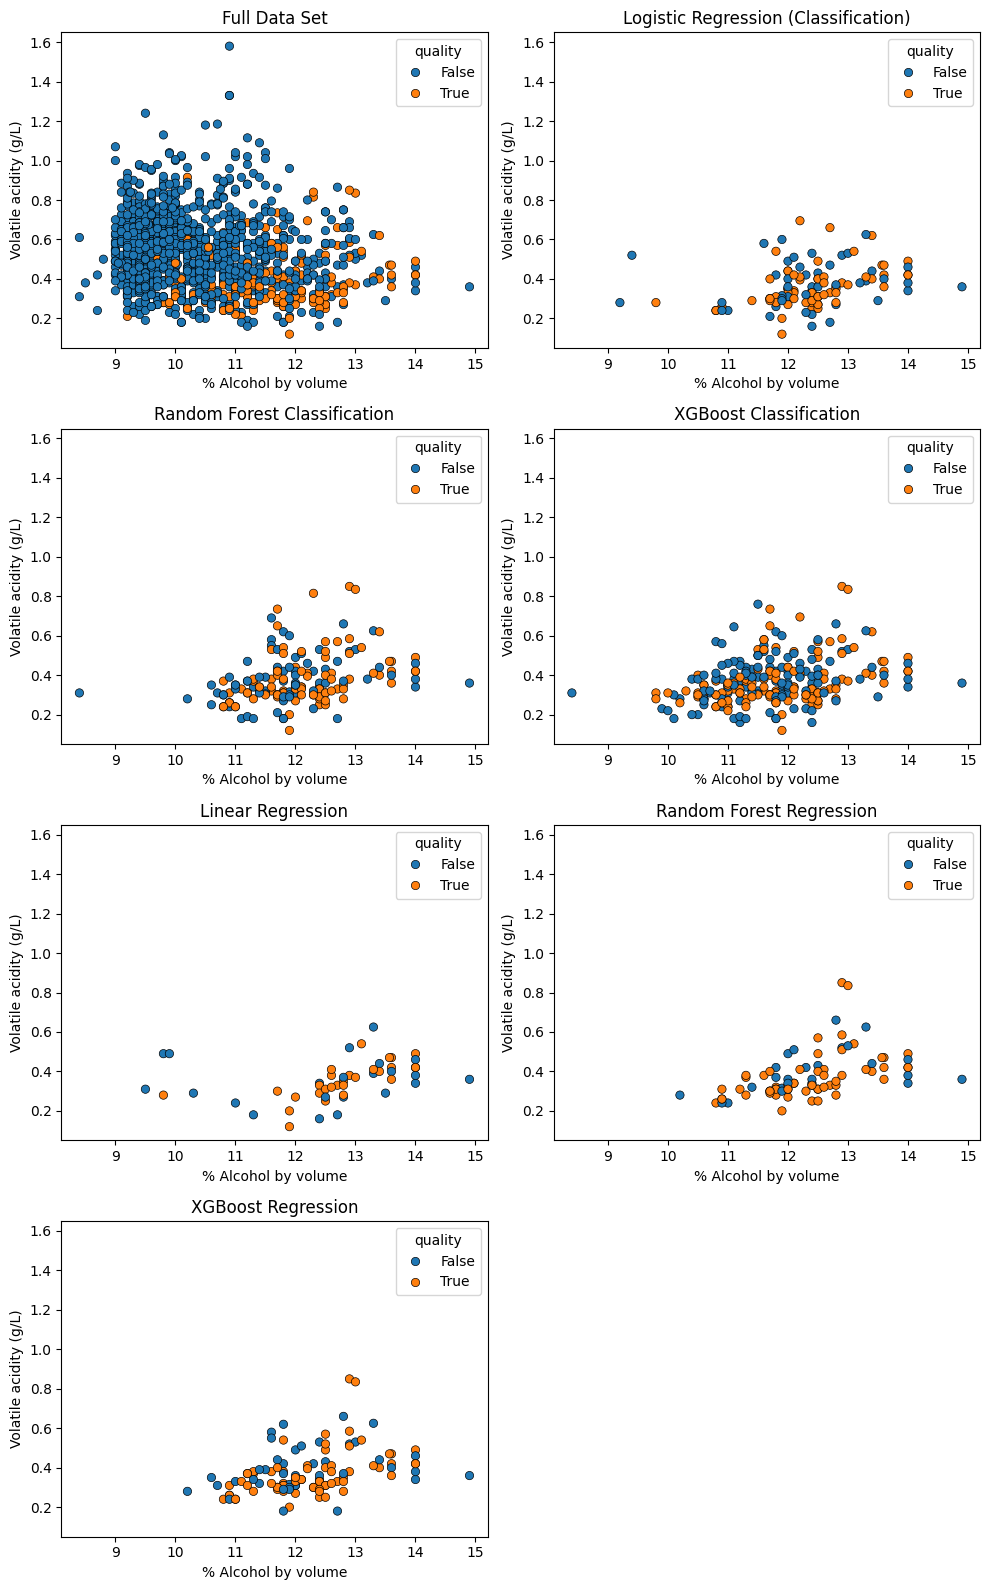

In [ ]:
final_results = {
    'Full Data Set': dataset,
    'Logistic Regression (Classification)': lc_results,
    'Random Forest Classification': rfc_results,
    'XGBoost Classification': xgbc_results,
    'Linear Regression': lr_results,
    'Random Forest Regression': rfr_results,
    'XGBoost Regression': xgbr_results,
}

plot_final_results(final_results)